# Demo 3: Decision Tree Classification


In [12]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.decomposition import PCA
from datetime import datetime

In [13]:
# Output directory
SCRIPT_DIR = os.getcwd()
OUT_DIR = os.path.join(SCRIPT_DIR, "introai3")
os.makedirs(OUT_DIR, exist_ok=True)
print("Saving to:", OUT_DIR)

Saving to: c:\Users\Jeen\Desktop\introai\introai3\introai3


## 1. Data Generation

In [14]:
X, y = make_classification(
    n_samples=600,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    class_sep=1.2,
    flip_y=0.02,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

## 2. Pipeline & GridSearchCV

In [15]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [3, 5, 8, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best Params:", best_params)

Best Params: {'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}


## 3. Evaluation

In [16]:
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.887

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89        74
           1       0.89      0.88      0.89        76

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150



## 4. Visualization & Saving Results

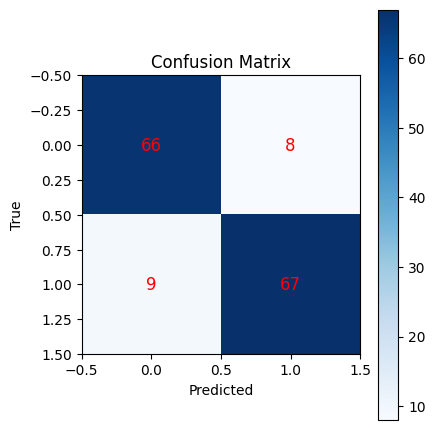

In [17]:
# 4.1 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 4.5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=12)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"), dpi=150)
plt.show()
plt.close()

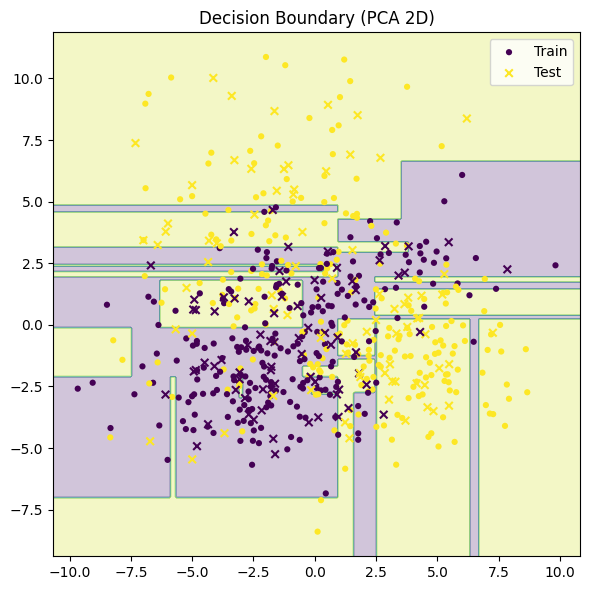

In [18]:
# 4.2 Decision Boundary in PCA 2D
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

dt_kwargs = {
    "criterion": best_params.get("clf__criterion", "gini"),
    "max_depth": best_params.get("clf__max_depth", None),
    "min_samples_split": best_params.get("clf__min_samples_split", 2),
    "min_samples_leaf": best_params.get("clf__min_samples_leaf", 1),
    "random_state": 42
}
clf2d = DecisionTreeClassifier(**dt_kwargs)
clf2d.fit(X_train_pca, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1, 300),
    np.linspace(X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1, 300)
)
Z = clf2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, alpha=0.25)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, marker="o", s=20, label="Train", edgecolors="none")
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, marker="x", s=30, label="Test")
plt.title("Decision Boundary (PCA 2D)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "decision_boundary_pca2d.png"), dpi=150)
plt.show()
plt.close()

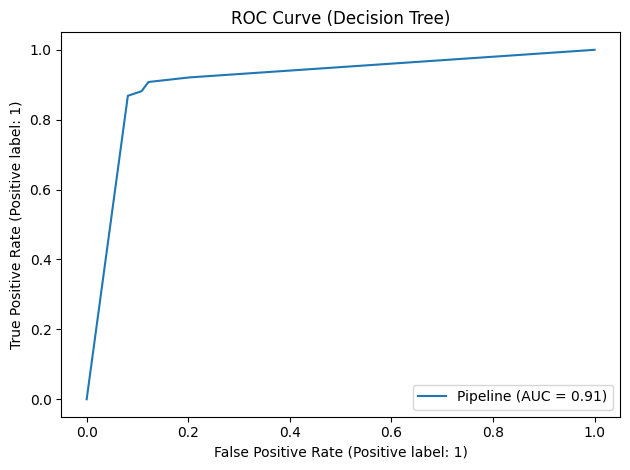

In [19]:
# 4.3 ROC Curve
RocCurveDisplay.from_estimator(grid.best_estimator_, X_test, y_test)
plt.title("ROC Curve (Decision Tree)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_curve.png"), dpi=150)
plt.show()
plt.close()

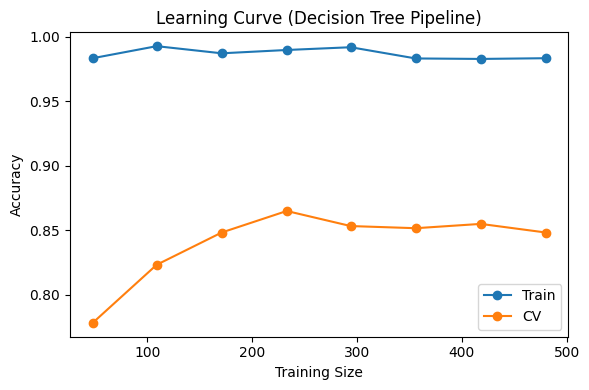

In [20]:
# 4.4 Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    grid.best_estimator_, X, y, cv=5, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), "o-", label="CV")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve (Decision Tree Pipeline)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "learning_curve.png"), dpi=150)
plt.show()
plt.close()

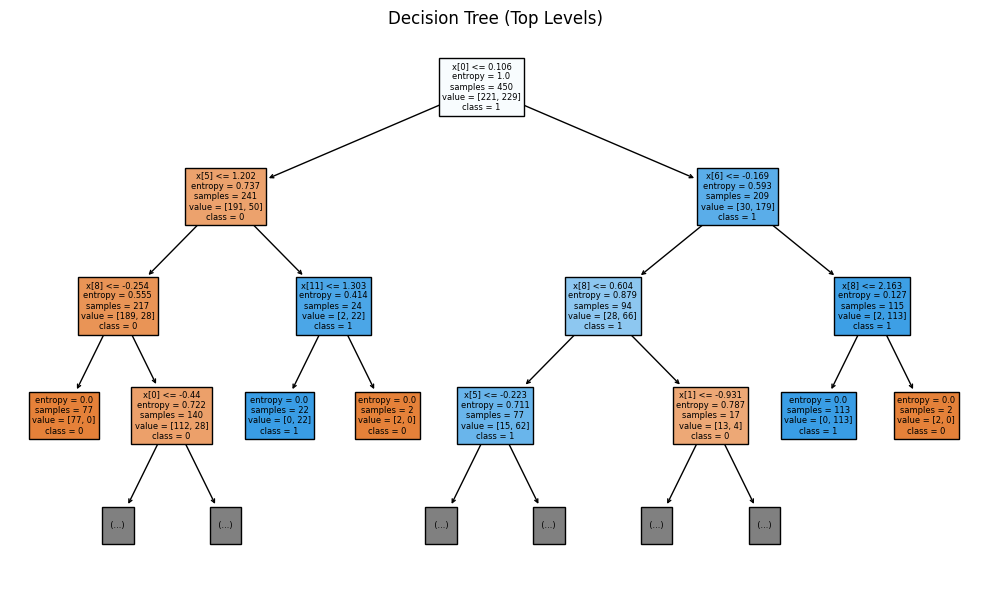

In [21]:
# (Optional) Save a small tree diagram from the best estimator
try:
    best_tree = grid.best_estimator_.named_steps["clf"]
    plt.figure(figsize=(10, 6))
    plot_tree(best_tree, filled=True, max_depth=3, feature_names=None, class_names=["0", "1"])
    plt.title("Decision Tree (Top Levels)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "tree_top_levels.png"), dpi=150)
    plt.show()
    plt.close()
except Exception as e:
    print("Skipping tree plot:", e)

## 5. Save Summary

In [22]:
summary_path = os.path.join(OUT_DIR, "summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(f"Timestamp: {datetime.now().isoformat()}\n")
    f.write(f"Best Params: {best_params}\n")
    f.write(f"Test Accuracy: {acc:.3f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))

print("Saved images to:", OUT_DIR)
print(" - confusion_matrix.png")
print(" - decision_boundary_pca2d.png")
print(" - roc_curve.png")
print(" - learning_curve.png")
print(" - tree_top_levels.png (optional)")
print("Summary saved to summary.txt")

Saved images to: c:\Users\Jeen\Desktop\introai\introai3\introai3
 - confusion_matrix.png
 - decision_boundary_pca2d.png
 - roc_curve.png
 - learning_curve.png
 - tree_top_levels.png (optional)
Summary saved to summary.txt
